In [1]:
import torch
import torch.nn as nn
from scratch_model import VisionTransformer

In [2]:
#check if we can run this code with GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [3]:
from train_utils import train, validate, save_model, save_plots, get_n_params
from save_best_model import SaveBestModel
save_best_model = SaveBestModel()

In [4]:
model_config = {
    "img_size": 32,
    "patch_size": 4,
    "in_chans": 3,
    "n_classes": 10,
    "embed_dim": 256,
    "depth": 12,
    "n_heads": 8,
    "mlp_ratio": 4.,
    "qkv_bias": True,}

In [5]:
RA_model = VisionTransformer(**model_config).to(device)
RA_model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=256, out_features=10, bias=True

In [6]:
get_n_params(RA_model)

9509642

In [7]:
import pickle
from torchvision.transforms import transforms
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [8]:
#import train data
with open('imbalanced_data.pkl', 'rb') as f:
    imbalanced_data = pickle.load(f)

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
from torchvision.transforms import RandAugment
augmenter = RandAugment()

In [10]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.26733429, 0.25643846, 0.27615047])
                                ])

trainsize = int(len(imbalanced_data)*0.8)
RA_train_data, RA_val_data = torch.utils.data.random_split(imbalanced_data, [trainsize, len(imbalanced_data) - trainsize])

cat_data = [(image,label) for image, label in RA_train_data if label == 3]
other_data = [(image,label) for image, label in RA_train_data if label != 3]

nb = 9

augment_data = []
for image, label in cat_data :
    img = [augmenter(image) for _ in range(nb)]
    img.append(image)
    for i in img :
        augment_data.append((i,label))

RA_data = augment_data + other_data
RA_train_set = [(transform(image), label) for image, label in RA_data]
RA_val_set = [(transform(image), label) for image, label in RA_val_data]

i = 0
j = []
for k in range(10) :
    for image ,label in RA_val_set :
        if label == k :
            i = i + 1
    j.append(i)
    i = 0
print("différents nombres de labels selon chaque classe dans le validation set :", j)

différents nombres de labels selon chaque classe dans le validation set : [1002, 1011, 977, 111, 1009, 1016, 1008, 1005, 991, 970]


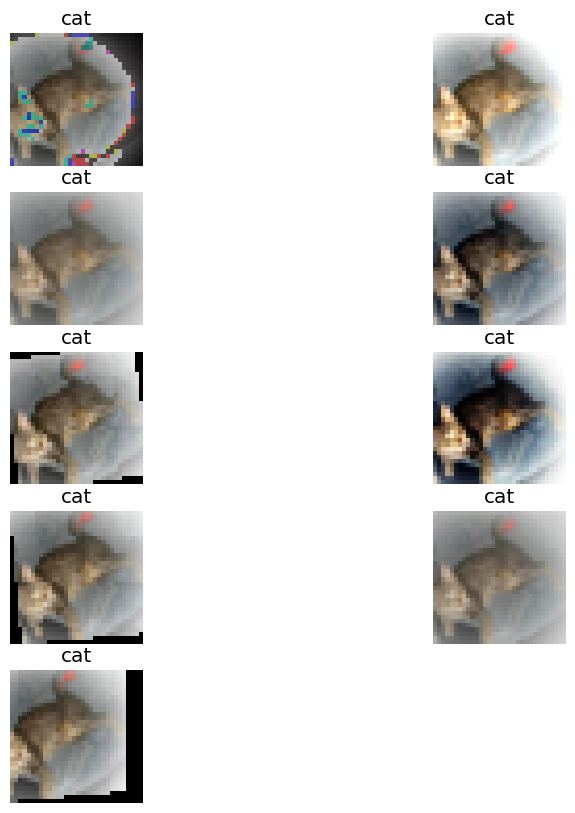

In [11]:
plt.figure(figsize=(10, 10))
for i in range(nb):
    plt.subplot(5, 2, i + 1)
    plt.imshow(augment_data[i][0])
    plt.title(class_names[augment_data[i][1]])
    plt.axis('off')

In [12]:
EPOCHS = 15
BATCH_SIZE = 128
LR = 3e-4

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RA_model.parameters(), lr = LR)

loader_kwargs = ({'num_workers' : 4, 'pin_memory': True} if torch.cuda.is_available() == True else {})
RA_train_loader = data.DataLoader(RA_train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, **loader_kwargs)
RA_val_loader = data.DataLoader(RA_val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, **loader_kwargs)

[INFO]: Epoch 1 of 20
Training


100%|██████████| 311/311 [00:39<00:00,  7.81it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 24.58it/s]


Training loss: 1.778, training acc: 34.485
Validation loss: 1.581, validation acc: 42.440

Best validation loss: 1.5807673633098602

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.78it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.21it/s]


Training loss: 1.357, training acc: 51.475
Validation loss: 1.293, validation acc: 53.835

Best validation loss: 1.2934754706091351

Saving best model for epoch: 2

--------------------------------------------------
[INFO]: Epoch 3 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.78it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.28it/s]


Training loss: 1.150, training acc: 59.141
Validation loss: 1.116, validation acc: 60.791

Best validation loss: 1.115632988512516

Saving best model for epoch: 3

--------------------------------------------------
[INFO]: Epoch 4 of 20
Training


100%|██████████| 311/311 [00:32<00:00,  9.65it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.18it/s]


Training loss: 1.020, training acc: 64.074
Validation loss: 1.066, validation acc: 62.747

Best validation loss: 1.0662196336521044

Saving best model for epoch: 4

--------------------------------------------------
[INFO]: Epoch 5 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.82it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 24.77it/s]


Training loss: 0.924, training acc: 67.282
Validation loss: 1.045, validation acc: 62.989

Best validation loss: 1.0448866114020348

Saving best model for epoch: 5

--------------------------------------------------
[INFO]: Epoch 6 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.82it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.10it/s]


Training loss: 0.836, training acc: 70.795
Validation loss: 1.017, validation acc: 64.956

Best validation loss: 1.0168267157342699

Saving best model for epoch: 6

--------------------------------------------------
[INFO]: Epoch 7 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.82it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.24it/s]


Training loss: 0.754, training acc: 73.316
Validation loss: 0.969, validation acc: 67.209

Best validation loss: 0.9688462565342585

Saving best model for epoch: 7

--------------------------------------------------
[INFO]: Epoch 8 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.83it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.30it/s]


Training loss: 0.676, training acc: 76.276
Validation loss: 0.988, validation acc: 66.330
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.85it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.38it/s]


Training loss: 0.614, training acc: 78.291
Validation loss: 0.974, validation acc: 67.176
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.83it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.32it/s]


Training loss: 0.545, training acc: 80.727
Validation loss: 1.022, validation acc: 67.220
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.83it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.14it/s]


Training loss: 0.490, training acc: 82.682
Validation loss: 1.046, validation acc: 66.308
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.83it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.15it/s]


Training loss: 0.428, training acc: 85.015
Validation loss: 1.084, validation acc: 67.352
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.85it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.31it/s]


Training loss: 0.372, training acc: 86.782
Validation loss: 1.106, validation acc: 67.670
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.84it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.20it/s]


Training loss: 0.329, training acc: 88.469
Validation loss: 1.144, validation acc: 67.736
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.83it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.27it/s]


Training loss: 0.278, training acc: 90.035
Validation loss: 1.204, validation acc: 67.440
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.83it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.25it/s]


Training loss: 0.250, training acc: 91.281
Validation loss: 1.177, validation acc: 68.648
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.83it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.23it/s]


Training loss: 0.218, training acc: 92.151
Validation loss: 1.309, validation acc: 67.484
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.83it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.34it/s]


Training loss: 0.189, training acc: 93.176
Validation loss: 1.309, validation acc: 67.813
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.82it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.20it/s]


Training loss: 0.170, training acc: 93.795
Validation loss: 1.334, validation acc: 66.857
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training


100%|██████████| 311/311 [00:31<00:00,  9.83it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.25it/s]


Training loss: 0.161, training acc: 94.153
Validation loss: 1.361, validation acc: 66.967
--------------------------------------------------
Saving final model...
TRAINING COMPLETE


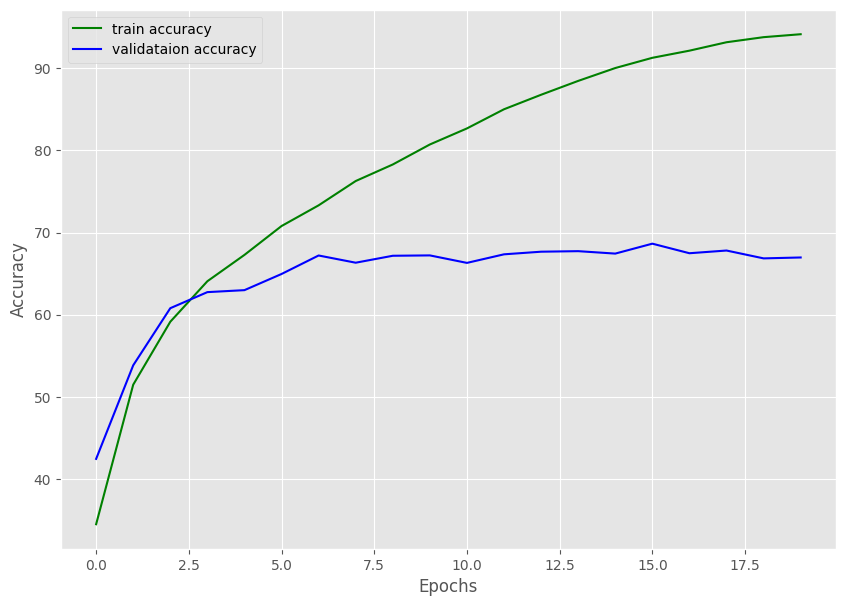

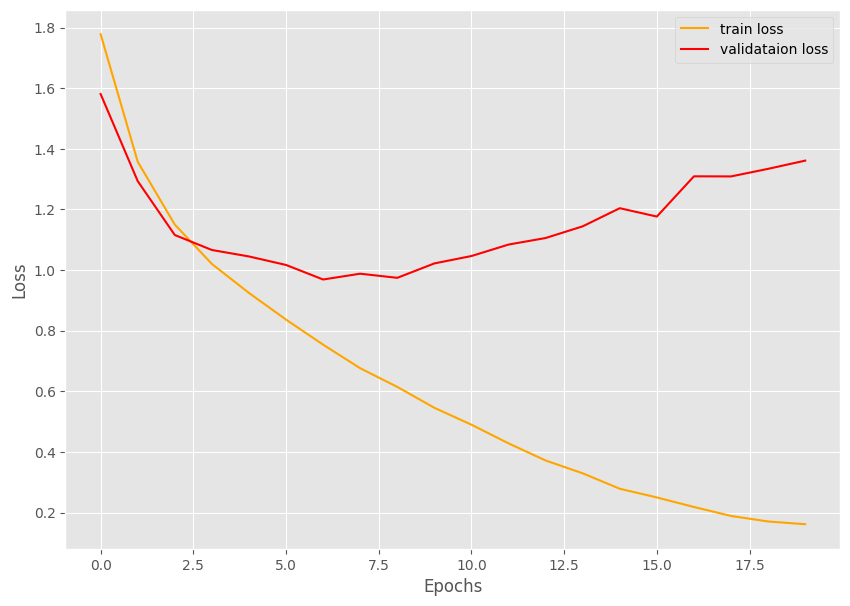

In [14]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(RA_model, RA_train_loader, 
                                            optimizer, loss_fn)
    valid_epoch_loss, valid_epoch_acc = validate(RA_model, RA_val_loader,  
                                                loss_fn)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    # save the best model till now if we have the least loss in the current epoch
    save_best_model(
        valid_epoch_loss, epoch, RA_model, optimizer, loss_fn, './models/RA_best_model.pth'
    )
    print('-'*50)
    
# save the trained model weights for a final time
save_model(EPOCHS, RA_model, optimizer, loss_fn, './models/RA_final_model.pth')
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss, './models/images/RA_')
print('TRAINING COMPLETE')

In [15]:
checkpoint = torch.load('./models/RA_best_model.pth')

model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_fn = checkpoint['loss']

In [16]:
prediction = []
with torch.no_grad():
    for _,label in RA_val_loader :
        image = _.to(device)
        pred = model(image)
        prediction.append(pred.cpu())

predicted_labels = []
for i in prediction:
    for j in i :
        predicted_labels.append(np.argmax(j.numpy()))

val_labels = []
for k,i in RA_val_set :
    val_labels.append(i)

In [17]:
val, tot = 0, 0
for i in range(len(val_labels)):
    if val_labels[i] == predicted_labels[i]:
        val += 1
    tot +=1
print(f"Précision totale sur le set de validation: {val/tot:.2f}")

valm, totm = 0, 0
liste = []
for i in range(len(val_labels)):
    if val_labels[i] == 3:
        liste.append([predicted_labels[i]])
        if val_labels[i] == predicted_labels[i] :
            valm += 1
        totm +=1
print(f"Précision sur la classe minoritaire du set de validation: {valm/totm:.2f}")

Précision totale sur le set de validation: 0.67
Précision sur la classe minoritaire du set de validation: 0.14
